# Power analysis for B2C experiments: conversion rate and ARPU

This notebook shows how to use the `tecore.power` module to:

- compute required sample size per group for a given minimal detectable effect (MDE);
- estimate achieved power for a given sample size;
- visualize the relationship between sample size, power, and effect size.

We focus on two typical B2C metrics:

- **Conversion rate (CR)** – binary metric (0/1);
- **Average revenue per user (ARPU)** – continuous metric.

In [14]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.style.use("default")
plt.rcParams["figure.figsize"] = (7, 4)

Import power analysis helpers from our package
from tecore.power import (
     sample_size_proportions,
     power_proportions,
     sample_size_means,
     power_means,
 )

## 1. Power analysis for conversion rate (CR)

Assume we have a B2C product with a baseline conversion rate of **5%**.
We want to be able to detect an **absolute increase of 1 percentage point** (from 5% to 6%)
with:

- significance level α = 0.05 (two-sided test),
- power = 0.80.

We will:

1. Compute the required sample size per group.
2. Check how power changes with different sample sizes.
3. Visualize the power curve.

In [15]:
# Baseline conversion rate
p_baseline = 0.05  # 5%

# Minimal detectable effect as absolute difference
mde_cr = 0.01      # +1 percentage point

alpha = 0.05
target_power = 0.80

result_cr = sample_size_proportions(
    p_baseline=p_baseline,
    mde=mde_cr,
    alpha=alpha,
    power=target_power,
    tail="two-sided",
)

print("Sample size for conversion rate experiment")
print(f"Baseline CR: {p_baseline:.3%}")
print(f"MDE (absolute): {mde_cr:.3%}")
print(f"Alpha (significance):{alpha:.2f}")
print(f"Target power: {target_power:.2f}")
print()
print(f"Required n per group: {result_cr.n_per_group}")
print(f"Total sample size: {result_cr.n_total}")

Sample size for conversion rate experiment
Baseline CR: 5.000%
MDE (absolute): 1.000%
Alpha (significance):0.05
Target power: 0.80

Required n per group: 8159
Total sample size: 16318


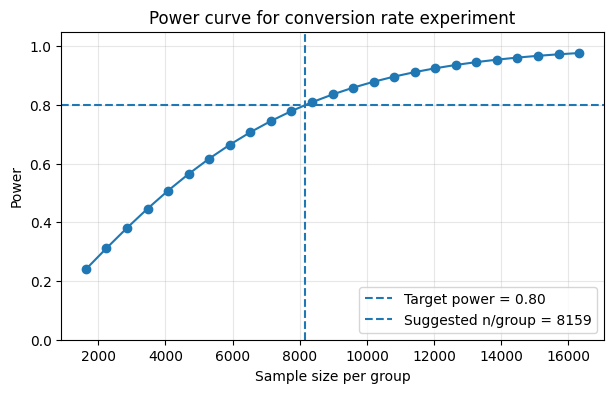

In [16]:
# Build a range of sample sizes around the suggested n_per_group
n_min = int(result_cr.n_per_group * 0.2)
n_max = int(result_cr.n_per_group * 2.0)
n_grid = np.linspace(n_min, n_max, 25, dtype=int)

powers = [
    power_proportions(
        p_baseline=p_baseline,
        mde=mde_cr,
        n_per_group=n,
        alpha=alpha,
        tail="two-sided",
    )
    for n in n_grid
]

# Plot power as a function of sample size per group
plt.figure()
plt.plot(n_grid, powers, marker="o")
plt.axhline(target_power, linestyle="--", label=f"Target power = {target_power:.2f}")
plt.axvline(result_cr.n_per_group, linestyle="--", label=f"Suggested n/group = {result_cr.n_per_group}")
plt.title("Power curve for conversion rate experiment")
plt.xlabel("Sample size per group")
plt.ylabel("Power")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Interpretation

- The vertical dashed line shows the **recommended sample size per group**.
- The horizontal dashed line shows the **target power** (e.g. 80%).
- Points below the line correspond to **underpowered experiments**:
  - the test will often fail to detect the desired +1 pp improvement,
    even if this effect is truly present.
- Points above the line provide more than enough power, but at the cost of
  additional traffic and time.

In practice, this kind of analysis helps decide:

- whether the experiment is worth running at all for a given MDE;
- how long it should run given typical daily traffic;
- whether it is realistic to detect very small effects.

## 2. Power analysis for ARPU (continuous metric)

Now consider a revenue-related metric such as **ARPU (average revenue per user)**.

Assume that from historical data we estimate:

- standard deviation of ARPU ≈ 5 units,
- we want to detect an **increase of 0.5 units** in ARPU.

Again, we will:

- compute required sample size per group;
- visualize how power grows with the sample size.

In [17]:
# Estimated standard deviation of ARPU from historical data
std_arpu = 5.0

# Minimal detectable effect in the same units as ARPU
mde_arpu = 0.5  # we want to detect +0.5 units

result_arpu = sample_size_means(
    std=std_arpu,
    mde=mde_arpu,
    alpha=alpha,
    power=target_power,
    tail="two-sided",
)

print("Sample size for ARPU experiment")
print(f"Std(ARPU): {std_arpu:.2f}")
print(f"MDE (absolute): {mde_arpu:.2f}")
print(f"Alpha (significance): {alpha:.2f}")
print(f"Target power: {target_power:.2f}")
print()
print(f"Required n per group: {result_arpu.n_per_group}")
print(f"Total sample size: {result_arpu.n_total}")

Sample size for ARPU experiment
Std(ARPU): 5.00
MDE (absolute): 0.50
Alpha (significance): 0.05
Target power: 0.80

Required n per group: 1570
Total sample size: 3140


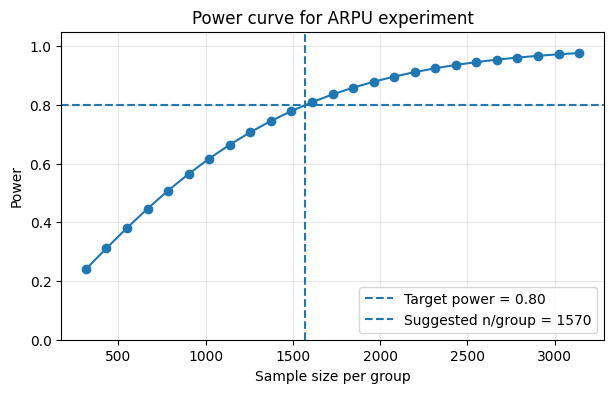

In [18]:
# Range of sample sizes for ARPU experiment
n_min_arpu = int(result_arpu.n_per_group * 0.2)
n_max_arpu = int(result_arpu.n_per_group * 2.0)
n_grid_arpu = np.linspace(n_min_arpu, n_max_arpu, 25, dtype=int)

powers_arpu = [
    power_means(
        std=std_arpu,
        mde=mde_arpu,
        n_per_group=n,
        alpha=alpha,
        tail="two-sided",
    )
    for n in n_grid_arpu
]

plt.figure()
plt.plot(n_grid_arpu, powers_arpu, marker="o")
plt.axhline(target_power, linestyle="--", label=f"Target power = {target_power:.2f}")
plt.axvline(result_arpu.n_per_group, linestyle="--", label=f"Suggested n/group = {result_arpu.n_per_group}")
plt.title("Power curve for ARPU experiment")
plt.xlabel("Sample size per group")
plt.ylabel("Power")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 3. How MDE changes the required sample size (CR example)

In practice, we often face a trade-off:

- small MDE → very large required sample size;
- larger MDE → smaller sample and shorter experiment, but we might miss small yet meaningful effects.

Below we fix:

- baseline CR = 5%,
- alpha = 0.05,
- power = 0.80,

and see how the required sample size changes for different absolute MDE values.

Required sample size per group for different MDE values (CR)
MDE = 0.500%  ->  n_per_group = 31235
MDE = 1.000%  ->  n_per_group = 8159
MDE = 1.500%  ->  n_per_group = 3781
MDE = 2.000%  ->  n_per_group = 2214


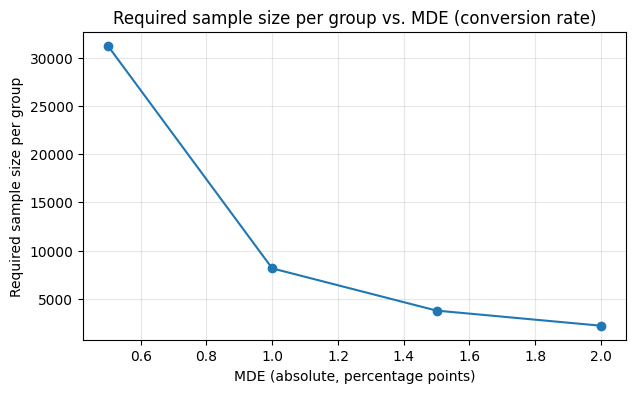

In [19]:
# Different absolute MDE values (in percentage points)
mde_values_cr = np.array([0.005, 0.01, 0.015, 0.02])  # 0.5pp, 1pp, 1.5pp, 2pp

sample_sizes = []
for mde_val in mde_values_cr:
    res = sample_size_proportions(
        p_baseline=p_baseline,
        mde=mde_val,
        alpha=alpha,
        power=target_power,
        tail="two-sided",
    )
    sample_sizes.append(res.n_per_group)

sample_sizes = np.array(sample_sizes)

print("Required sample size per group for different MDE values (CR)")
for mde_val, n in zip(mde_values_cr, sample_sizes):
    print(f"MDE = {mde_val:.3%}  ->  n_per_group = {n}")

plt.figure()
plt.plot(mde_values_cr * 100, sample_sizes, marker="o")
plt.title("Required sample size per group vs. MDE (conversion rate)")
plt.xlabel("MDE (absolute, percentage points)")
plt.ylabel("Required sample size per group")
plt.grid(True, alpha=0.3)
plt.show()

## 4. How MDE affects power at a fixed sample size (CR example)

Another way to look at the same trade-off:

- fix a certain sample size per group (for example, what we can realistically afford);
- see how power changes for different MDE values.

Below we fix `n_per_group` at the value recommended for detecting a **1 pp** increase,
and then check the achieved power for different MDE values.
Smaller MDEs will have lower power, larger MDEs — higher power.

Fixed sample size per group: n = 8159
Achieved power for different MDE values (CR)
MDE = 0.500%  ->  power = 0.299
MDE = 1.000%  ->  power = 0.800
MDE = 1.500%  ->  power = 0.984
MDE = 2.000%  ->  power = 1.000


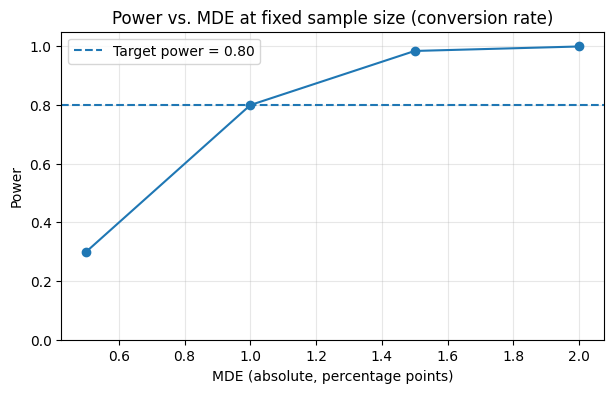

In [20]:
# We reuse the same mde_values_cr grid
n_fixed = result_cr.n_per_group  # sample size needed to detect 1 pp increase

powers_vs_mde = []
for mde_val in mde_values_cr:
    pwr = power_proportions(
        p_baseline=p_baseline,
        mde=mde_val,
        n_per_group=n_fixed,
        alpha=alpha,
        tail="two-sided",
    )
    powers_vs_mde.append(pwr)

powers_vs_mde = np.array(powers_vs_mde)

print(f"Fixed sample size per group: n = {n_fixed}")
print("Achieved power for different MDE values (CR)")
for mde_val, pwr in zip(mde_values_cr, powers_vs_mde):
    print(f"MDE = {mde_val:.3%}  ->  power = {pwr:.3f}")

plt.figure()
plt.plot(mde_values_cr * 100, powers_vs_mde, marker="o")
plt.axhline(target_power, linestyle="--", label=f"Target power = {target_power:.2f}")
plt.title("Power vs. MDE at fixed sample size (conversion rate)")
plt.xlabel("MDE (absolute, percentage points)")
plt.ylabel("Power")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 3. Comparing CR and ARPU examples

Key points from the two examples:

- For **binary metrics** (conversion rate), sample size depends on:
  - baseline rate,
  - absolute effect size (in percentage points),
  - desired power and alpha.

- For **continuous metrics** (ARPU), sample size depends on:
  - standard deviation of the metric,
  - absolute effect size (in metric units),
  - desired power and alpha.

In both cases, power analysis helps answer practical questions:

- Is it realistic to detect the desired effect with our traffic?
- How long should the experiment run?
- Should we reconsider the MDE or the design of the experiment?

This notebook is intentionally simple and focuses on **clarity**.
In real projects, you would:

- estimate baseline metrics and standard deviations from historical data,
- consider additional factors (seasonality, segmentation, uneven allocation),
- integrate these functions into your experimentation platform.